In [2]:
from lir_proteome_screen_pssm import environment as env
from lir_proteome_screen_pssm import pssms
import pandas as pd
import numpy as np
import logomaker as lm
import matplotlib.pyplot as plt
plt.style.use('custom_standard')
plt.style.use('custom_small')
import seaborn as sns
import lir_proteome_screen_pssm.sequence_utils as seqtools

from pathlib import Path

%load_ext autoreload
%autoreload 2

Thoughts from first notebook


- more sequence information from hits at z-scores greater than ~2.4. But sequences in this range don't have many "new-lir" hits, so they look like the previously known binding sequences. 
  - Could using a higher z-score threshold be too restrictive? We know that lc3b can bind these "new-lirs" (lots of good BLI data) so we would want a pssm to capture that, ideally. It might be beyond a PSSM to do this while also retaining the sequence features that define a good canonical/biological binder
- Low counts are causing some really weird PSSMs. mostly artifacts. Need to find a way to deal with this that actually makes sense logically and that performs well. Will probably be a custom solution, involving a low count cutoff that defaults to 0 rather than penalizing based on a background distribution.
- I should consider composite scores from multiple PSSMs.

Ideas
- try to find a stringent nonbinder set
- try to find a non-canonical lir binder set to see if there are any sequence features that are common to them
- deal with Low counts to generate a more reliable pssm

<br>

Features that I want a PSSM (or any score) to have (ideally).
- captures the major contributions to binding (the major sequence features that are enriched in the binding sequences)
  - W at the first position, N-terminal negative charge, etc.
- penalizes sequence features that are enriched in non-binding sequences? (if there even are any features that stick out in a pssm - this seems unlikely)
- allows for flexibility at the last position to capture the new motif.

---

TODO:
- Look for "new-lir" sequence preferences
- Attempt to define a higher confidence non-binder set

In [8]:
def normalize_positions(mat: pd.DataFrame) -> pd.DataFrame:
    """
    normalize each position in the matrix so that it sums to 1

    Parameters
    ----------
    mat : pd.DataFrame
        DataFrame in the logomaker format (rows = positions, columns = amino acids)
    
    Returns
    -------
    pd.DataFrame
        DataFrame in the logomaker format (rows = positions, columns = amino acids)
        where each position sums to 1
    """
    freq_df = mat.copy()
    freq_df = freq_df.div(freq_df.sum(axis=1), axis=0)
    return freq_df

# "non-canonical" [FWY]..[LVIWFMY] but not [FWY]..[LVI]?

In [4]:
def get_regex_matches(s: pd.Series, regex: str):
    matches = list(seqtools.get_regex_matches(regex, s["ID"]))
    # if len(matches) == 0:
    #     return
    return matches


REGEX = "...[FWY]..[WFY]..."
df = pd.read_csv(env.RAWFILEPATHS.full_screening_table, sep='\t')
df["regex_matches"] = df.apply(get_regex_matches, axis=1, regex=REGEX)
df["num_regex_matches"] = df["regex_matches"].apply(lambda x: len(x))
df["num_regex_matches"].value_counts()
df_multi = df[df["num_regex_matches"] > 1].copy()
df_multi = df_multi.explode("regex_matches")
df_single = df[df["num_regex_matches"] == 1].copy()
df_single["regex_matches"] = df_single["regex_matches"].apply(lambda x: x[0])
df = pd.concat([df_multi, df_single])
df[["motif", "motif_start", "motif_end"]] = pd.DataFrame(
    df["regex_matches"].tolist(), index=df.index
)

In [5]:
df

,Unnamed: 0,ID,ER 0,ER 1,ER 3,ER 4,ER 5,ER 6,Input Count,1 Count,...,Score (Bits),z_score_4,z_score_5,z_score_6,avg_z_score,regex_matches,num_regex_matches,motif,motif_start,motif_end
80,85,ESEDEESYDTESEFTEFTEDNWPYDDWCLVASV,0,5.563254,8.718843,9.667107,9.697579,9.312026,40,1031,...,51.2,2.534295,2.614791,2.693072,2.61,"(ESEFTEFTED, 10, 19)",2,ESEFTEFTED,10,19
80,85,ESEDEESYDTESEFTEFTEDNWPYDDWCLVASV,0,5.563254,8.718843,9.667107,9.697579,9.312026,40,1031,...,51.2,2.534295,2.614791,2.693072,2.61,"(NWPYDDWCLV, 20, 29)",2,NWPYDDWCLV,20,29
132,139,PALFKSYAEYGHFVHSYCSFGSSC,0,5.870838,8.000173,8.999683,8.420739,8.566071,10,319,...,34.7,2.249622,2.084049,2.380598,2.24,"(PALFKSYAEY, 0, 9)",2,PALFKSYAEY,0,9
132,139,PALFKSYAEYGHFVHSYCSFGSSC,0,5.870838,8.000173,8.999683,8.420739,8.566071,10,319,...,34.7,2.249622,2.084049,2.380598,2.24,"(VHSYCSFGSS, 13, 22)",2,VHSYCSFGSS,13,22
380,387,LTRYLNWIGVPTREFNVGQYRRDVVKTYKSFEFL,0,3.119975,6.613137,7.554283,7.042227,7.866938,23,109,...,73.2,1.633123,1.511045,2.087736,1.74,"(LTRYLNWIGV, 0, 9)",2,LTRYLNWIGV,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
966428,968929,YWMNFLLYFNVVKIVVFLLLGGK,0,NaN,NaN,NaN,NaN,NaN,1,0,...,24.6,NaN,NaN,NaN,NaN,"(WMNFLLYFNV, 1, 10)",1,WMNFLLYFNV,1,10
966429,968930,YWMNFLLYFNVLKIVVFLLLCWK,0,NaN,NaN,NaN,NaN,NaN,220,0,...,24.3,NaN,NaN,NaN,NaN,"(WMNFLLYFNV, 1, 10)",1,WMNFLLYFNV,1,10
966434,968935,YWITIDNPYVVAWHGYATGRLAPGIRGSPRLGYLVA,0,3.249749,NaN,NaN,NaN,NaN,27,140,...,78.2,NaN,NaN,NaN,NaN,"(VVAWHGYATG, 9, 18)",1,VVAWHGYATG,9,18
966439,968940,YWKNESGTWIQYGEEKDKRKNSNVDSSYLESLYQSC,0,0.565013,NaN,NaN,NaN,NaN,31,25,...,79.0,NaN,NaN,NaN,NaN,"(SGTWIQYGEE, 5, 14)",1,SGTWIQYGEE,5,14


In [6]:
temp_fg = df[df['avg_z_score']>0].copy()
# with open('temp.fasta', 'w') as f:
#     for c,i in enumerate(temp_fg.motif.unique()):
#         f.write(f">{c}\n")
#         f.write(f"{i}\n")
print(len(df[df['avg_z_score']>0].motif.unique()))

temp_bg = df[df['Input Count'] > 100].copy()
print(len(temp_bg.motif.unique()))
# with open('temp_bg.fasta', 'w') as f:
#     for c,i in enumerate(temp_bg.motif.unique()):
#         f.write(f">{c}\n")
#         f.write(f"{i}\n")

521
18539


Text(0.5, 1.0, 'foreground - background')

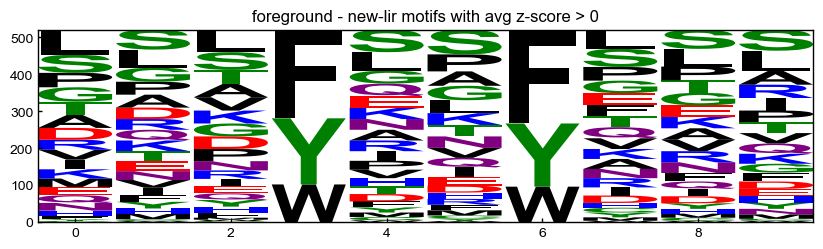

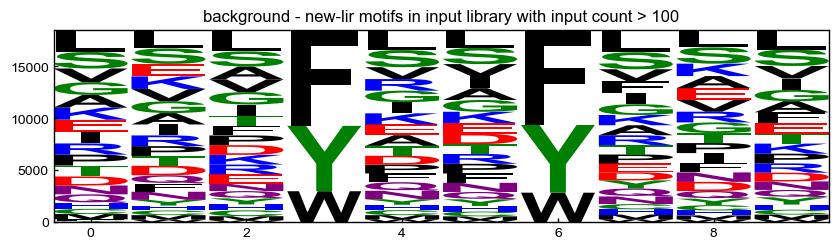

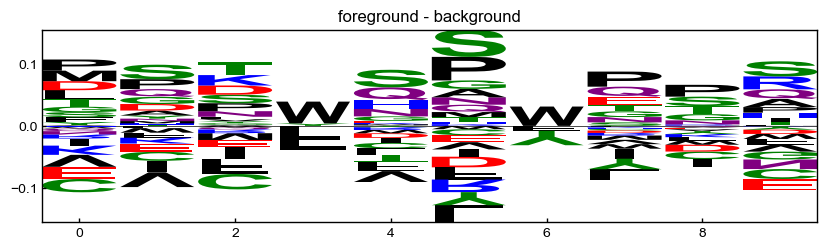

In [10]:
fig, ax = plt.subplots(figsize=(10, 2.5))
pssms.plot_logo(pssms.alignment_2_counts(temp_fg.motif.unique()), ax=ax)
ax.set_title("foreground - new-lir motifs with avg z-score > 0")
fig, ax = plt.subplots(figsize=(10, 2.5))
pssms.plot_logo(pssms.alignment_2_counts(temp_bg.motif.unique()), ax=ax)
ax.set_title("background - new-lir motifs in input library with input count > 100")
fig, ax = plt.subplots(figsize=(10, 2.5))
pssms.plot_logo(normalize_positions(pssms.alignment_2_counts(temp_fg.motif.unique())) - normalize_positions(pssms.alignment_2_counts(temp_bg.motif.unique())), ax=ax)
ax.set_title("foreground - background")

binned by z-score

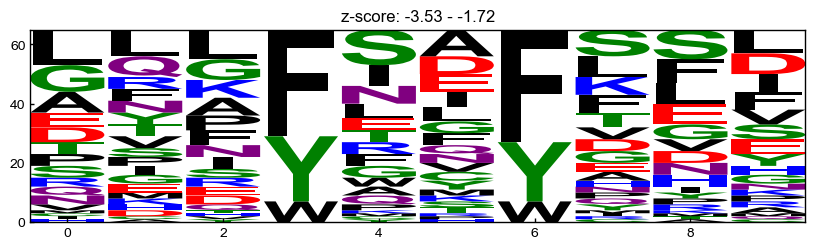

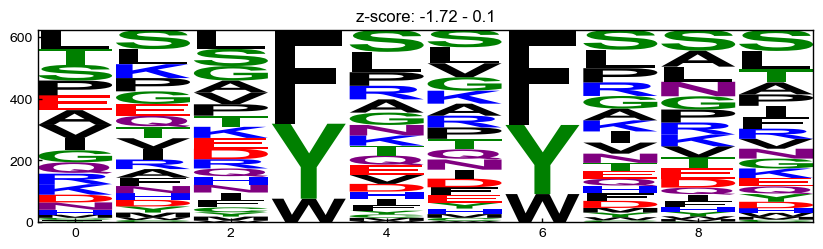

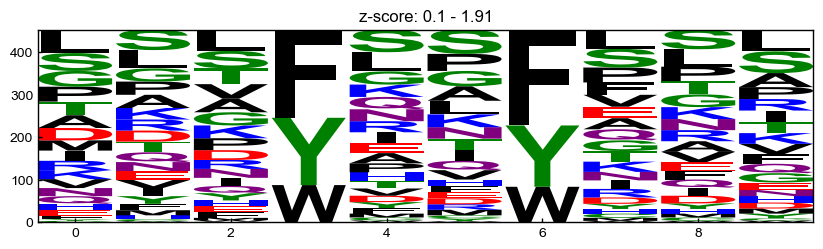

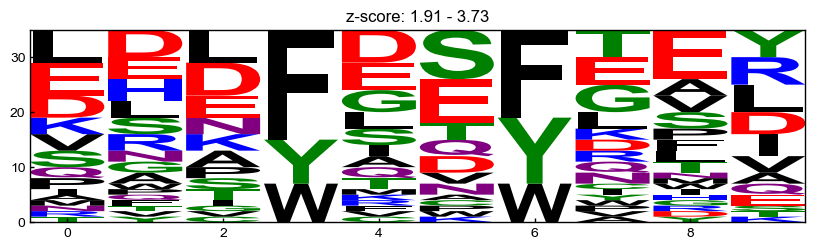

In [36]:
# define ranges between min and max avg_z_score
def get_z_score_range(df, min_z_score, max_z_score):
    df_filt = df[(df["avg_z_score"] >= min_z_score) & (df["avg_z_score"] < max_z_score)].copy()
    return df_filt


min_z_score = df["avg_z_score"].min()
max_z_score = df["avg_z_score"].max()
z_score_range = np.linspace(min_z_score, max_z_score, 5)
z_score_range = np.round(z_score_range, 2)
# split range into bins
z_score_bins = []
for i in range(len(z_score_range) - 1):
    z_score_bins.append([z_score_range[i], z_score_range[i + 1]])
z_score_bins[-1][1] += 0.01


for i, z_score_bin in enumerate(z_score_bins):
    min_z_score = z_score_bin[0]
    max_z_score = z_score_bin[1]
    df_filt = get_z_score_range(df, min_z_score, max_z_score)
    ax = pssms.plot_logo(pssms.alignment_2_counts(df_filt["motif"]))
    ax.set_title(f"z-score: {min_z_score} - {max_z_score}")

Text(0.5, 1.0, 'z-score: 2.01 - 3.72')

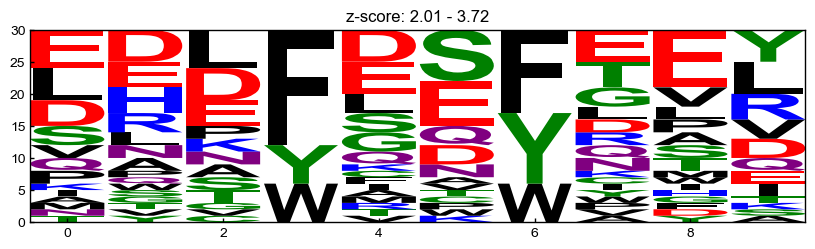

In [43]:
df_filt = get_z_score_range(df, 2, 5)
ax = pssms.plot_logo(pssms.alignment_2_counts(df_filt["motif"]))
ax.set_title(f"z-score: {df_filt['avg_z_score'].min()} - {df_filt['avg_z_score'].max()}")

binned by rank

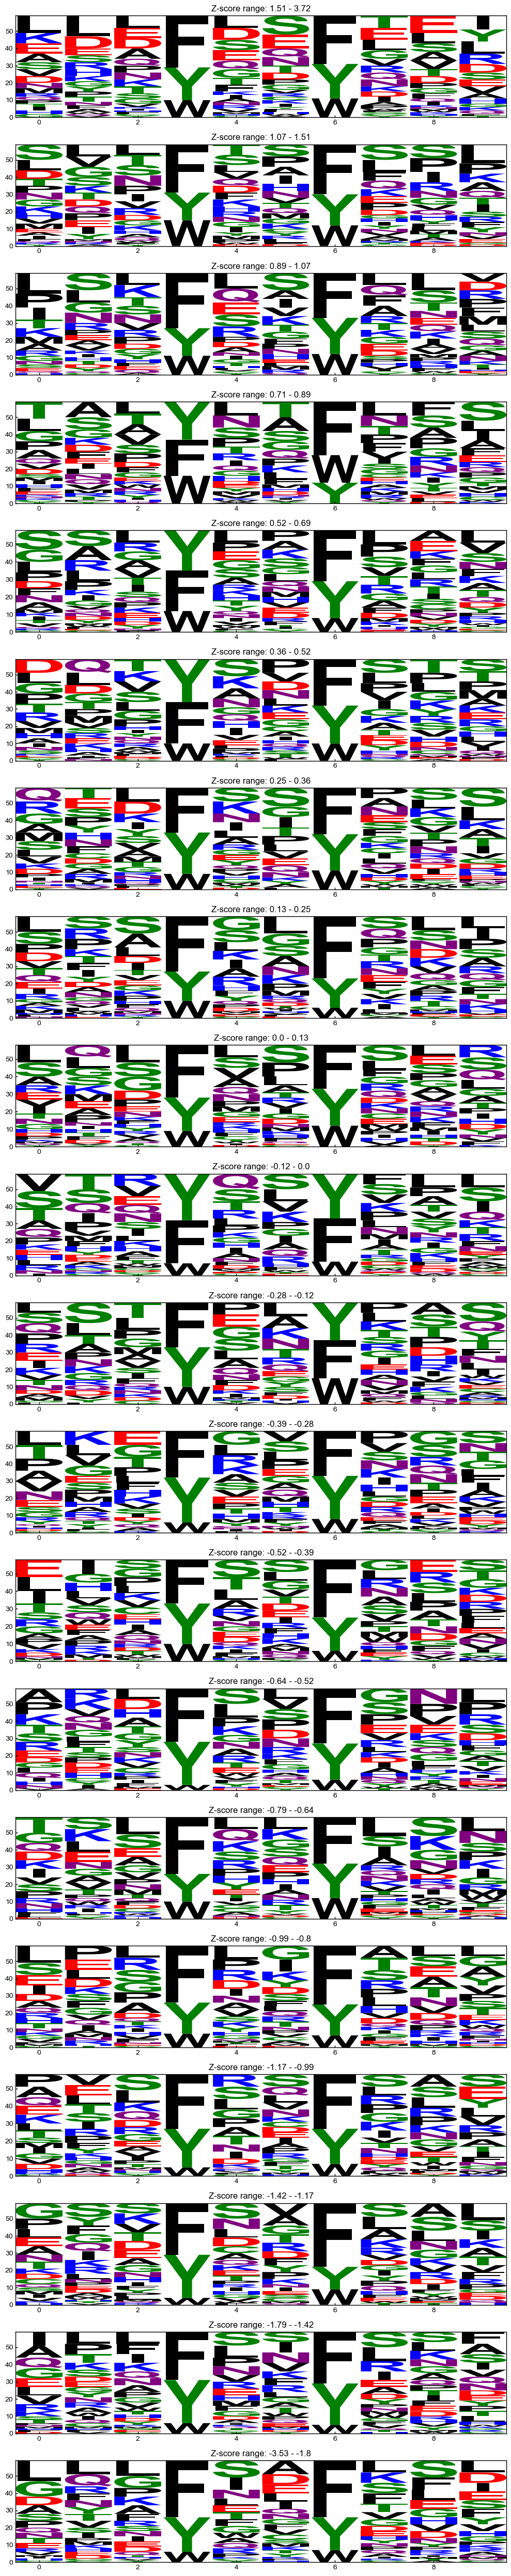

In [38]:
df_zs = df[~df["avg_z_score"].isna()].copy()
df_zs = df_zs.sort_values(by = "avg_z_score", ascending = False)
df_zs = df_zs.reset_index(drop=True)
# create 10 ranges from df_zs.index
df_zs["z_score_range"] = pd.cut(df_zs.index, bins=20, labels=False)
n_plots = len(df_zs["z_score_range"].unique())
fig, axes = plt.subplots(nrows = n_plots, ncols = 1, figsize=(10, 2.5*n_plots))
for i, ax in zip(df_zs["z_score_range"].unique(), axes):
    df_filt = df_zs[df_zs["z_score_range"] == i]
    pssms.plot_logo(pssms.alignment_2_counts(df_filt["motif"]), ax=ax)
    ax.set_title(f"Z-score range: {df_filt['avg_z_score'].min()} - {df_filt['avg_z_score'].max()}") 
plt.tight_layout()

## non-binders

In [ ]:
def get_regex_matches(s: pd.Series, regex: str):
    matches = list(seqtools.get_regex_matches(regex, s["ID"]))
    # if len(matches) == 0:
    #     return
    return matches


REGEX = "....[FWY]..[LVIWFY]"
df = pd.read_csv(env.RAWFILEPATHS.full_screening_table, sep='\t')
df["regex_matches"] = df.apply(get_regex_matches, axis=1, regex=REGEX)
df["num_regex_matches"] = df["regex_matches"].apply(lambda x: len(x))
df["num_regex_matches"].value_counts()
df_multi = df[df["num_regex_matches"] > 1].copy()
df_multi = df_multi.explode("regex_matches")
df_single = df[df["num_regex_matches"] == 1].copy()
df_single["regex_matches"] = df_single["regex_matches"].apply(lambda x: x[0])
df = pd.concat([df_multi, df_single])
df[["motif", "motif_start", "motif_end"]] = pd.DataFrame(
    df["regex_matches"].tolist(), index=df.index
)

In [17]:
df

,Unnamed: 0,ID,ER 0,ER 1,ER 3,ER 4,ER 5,ER 6,Input Count,1 Count,...,Score (Bits),z_score_4,z_score_5,z_score_6,avg_z_score,regex_matches,num_regex_matches,motif,motif_start,motif_end
11,11,DIDNFDIDDFDDDDDWEDIMHNLAASKSSTAAYQPI,0,5.401556,9.671734,11.426329,12.075933,12.376433,973,22420,...,75.5,3.284647,3.603398,3.976728,3.62,"(DDDDWEDI, 11, 18)",2,DDDDWEDI,11,18
11,11,DIDNFDIDDFDDDDDWEDIMHNLAASKSSTAAYQPI,0,5.401556,9.671734,11.426329,12.075933,12.376433,973,22420,...,75.5,3.284647,3.603398,3.976728,3.62,"(STAAYQPI, 28, 35)",2,STAAYQPI,28,35
17,19,GMKYIETSARDAINVEKAFTDLTRDIYELVKRGENY,0,4.934247,9.532716,11.329670,11.656937,11.411561,12,200,...,69.3,3.243420,3.429234,3.572551,3.42,"(VEKAFTDL, 14, 21)",2,VEKAFTDL,14,21
17,19,GMKYIETSARDAINVEKAFTDLTRDIYELVKRGENY,0,4.934247,9.532716,11.329670,11.656937,11.411561,12,200,...,69.3,3.243420,3.429234,3.572551,3.42,"(TRDIYELV, 22, 29)",2,TRDIYELV,22,29
20,23,YLGQLEHEDIDTSADAVEDLTEAEWEDLTQQYYSLV,0,5.857058,9.449375,11.147782,11.561737,11.270682,124,3918,...,80.1,3.165840,3.389663,3.513537,3.36,"(TEAEWEDL, 20, 27)",2,TEAEWEDL,20,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
966439,968940,YWKNESGTWIQYGEEKDKRKNSNVDSSYLESLYQSC,0,0.565013,NaN,NaN,NaN,NaN,31,25,...,79.0,NaN,NaN,NaN,NaN,"(ESGTWIQY, 4, 11)",1,ESGTWIQY,4,11
966441,968942,YWKKETSKDTETVLKTTGYSDRPTARRKPDYEPVK,0,NaN,NaN,NaN,NaN,NaN,9,0,...,73.6,NaN,NaN,NaN,NaN,"(RKPDYEPV, 26, 33)",1,RKPDYEPV,26,33
966443,968944,YWKLTIMSFIKLMVVNPSILIVSFMVMKLPKMCMK,0,NaN,NaN,NaN,NaN,NaN,9,0,...,22.3,NaN,NaN,NaN,NaN,"(TIMSFIKL, 4, 11)",1,TIMSFIKL,4,11
966445,968946,YWKYGEAASTECNSVCFGDHTQPCGGDGRIILFDTL,0,NaN,NaN,NaN,NaN,NaN,34,0,...,81.6,NaN,NaN,NaN,NaN,"(RIILFDTL, 28, 35)",1,RIILFDTL,28,35


In [ ]:
print(len(df))
df = df[df["Count sum"] > 40].copy()
print(len(df))
df=df.reset_index(drop=True)

515401
166036


In [21]:
# declare the first one as the "WT"
count_cols = [i for i in df.columns if "Count" in i and i != "Count sum"]
wt_counts = df.loc[0, count_cols]
wt_counts

Input Count       973
1 Count         22420
3 Count        228749
4 Count        124504
5 Count         31872
6 Count         32761
Name: 0, dtype: object

In [22]:
for i in count_cols:
    df[i.split(" ")[0] + " - WT normalized"] = np.log2(df[i] / wt_counts[i])

/Users/jackson/mambaforge/envs/lir_proteome_screen_pssm/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/jackson/mambaforge/envs/lir_proteome_screen_pssm/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/jackson/mambaforge/envs/lir_proteome_screen_pssm/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/jackson/mambaforge/envs/lir_proteome_screen_pssm/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/jackson/mambaforge/envs/lir_proteome_screen_pssm/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWa

In [23]:
df

,Unnamed: 0,ID,ER 0,ER 1,ER 3,ER 4,ER 5,ER 6,Input Count,1 Count,...,num_regex_matches,motif,motif_start,motif_end,Input - WT normalized,1 - WT normalized,3 - WT normalized,4 - WT normalized,5 - WT normalized,6 - WT normalized
0,11,DIDNFDIDDFDDDDDWEDIMHNLAASKSSTAAYQPI,0,5.401556,9.671734,11.426329,12.075933,12.376433,973,22420,...,2,DDDDWEDI,11,18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,11,DIDNFDIDDFDDDDDWEDIMHNLAASKSSTAAYQPI,0,5.401556,9.671734,11.426329,12.075933,12.376433,973,22420,...,2,STAAYQPI,28,35,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,19,GMKYIETSARDAINVEKAFTDLTRDIYELVKRGENY,0,4.934247,9.532716,11.329670,11.656937,11.411561,12,200,...,2,VEKAFTDL,14,21,-6.341333,-6.808642,-6.480351,-6.437993,-6.760330,-7.306205
3,19,GMKYIETSARDAINVEKAFTDLTRDIYELVKRGENY,0,4.934247,9.532716,11.329670,11.656937,11.411561,12,200,...,2,TRDIYELV,22,29,-6.341333,-6.808642,-6.480351,-6.437993,-6.760330,-7.306205
4,23,YLGQLEHEDIDTSADAVEDLTEAEWEDLTQQYYSLV,0,5.857058,9.449375,11.147782,11.561737,11.270682,124,3918,...,2,TEAEWEDL,20,27,-2.972100,-2.516597,-3.194458,-3.250647,-3.486296,-4.077851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166031,968877,YWALSGYDFCKVIRRIFQTMASRAASKQLTQLFST,0,NaN,NaN,NaN,NaN,NaN,48,0,...,1,SGYDFCKV,4,11,-4.341333,-inf,-inf,-inf,-inf,-inf
166032,968885,YWDAPLGILICATKSRLFQCLVHFRLIPLICVFSL,0,NaN,NaN,NaN,NaN,NaN,45,0,...,1,KSRLFQCL,13,20,-4.434443,-inf,-inf,-inf,-inf,-inf
166033,968897,YWEELENLVQSKKIVAIGTSDLDKTQLEQLYQWAQV,0,NaN,NaN,NaN,NaN,NaN,56,0,...,1,QLYQWAQV,28,35,-4.118941,-inf,-inf,-inf,-inf,-inf
166034,968935,YWITIDNPYVVAWHGYATGRLAPGIRGSPRLGYLVA,0,3.249749,NaN,NaN,NaN,NaN,27,140,...,1,YVVAWHGY,8,15,-5.171408,-7.323216,-inf,-inf,-inf,-inf


In [30]:
df2 = df.copy()
# drop rows with -inf values
df2 = df2.replace(-np.inf, np.nan)
df2 = df2.dropna(subset=["Input - WT normalized", "1 - WT normalized"])
df2["input to sort1 difference"] =  df2["1 - WT normalized"] - df2["Input - WT normalized"]

<Axes: >

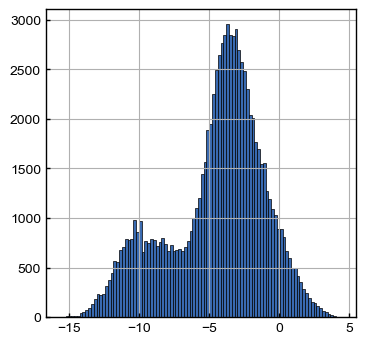

In [31]:
df2["input to sort1 difference"].hist(bins=100)

In [32]:
df2 = df2.sort_values(by="input to sort1 difference")
df2.head(2000)

,Unnamed: 0,ID,ER 0,ER 1,ER 3,ER 4,ER 5,ER 6,Input Count,1 Count,...,motif,motif_start,motif_end,Input - WT normalized,1 - WT normalized,3 - WT normalized,4 - WT normalized,5 - WT normalized,6 - WT normalized,input to sort1 difference
127034,523772,MKDQHLRGFFSDSTSFNILMDMLFIKGKYKSALQVL,0,-10.216082,NaN,NaN,NaN,NaN,2182,1,...,DSTSFNIL,11,18,1.165139,-14.452499,NaN,NaN,NaN,NaN,-15.617638
101608,303732,KGYVITGIYSEECFAAVNQICCKSSSLLLARHTEG,0,-10.004996,NaN,NaN,NaN,NaN,1885,1,...,SEECFAAV,9,16,0.954053,-14.452499,NaN,NaN,NaN,NaN,-15.406551
134002,591848,MVCTFLRAVQYTEKLHRSSAKRLLLPYIVLNKAYLK,0,-9.972487,NaN,NaN,NaN,NaN,1843,1,...,LLLPYIVL,22,29,0.921544,-14.452499,NaN,NaN,NaN,NaN,-15.374043
126030,515172,MFAVQIKLPLLFPASWRRPGLGCWCATRGSWRLWL,0,-9.943229,NaN,NaN,NaN,NaN,1806,1,...,TRGSWRLW,26,33,0.892286,-14.452499,NaN,NaN,NaN,NaN,-15.344785
86911,180596,RFACSTVVRAYVLLLRSYQQNSAHTNHCIVKMLHRL,0,-9.852567,NaN,NaN,NaN,NaN,1696,1,...,VVRAYVLL,6,13,0.801624,-14.452499,NaN,NaN,NaN,NaN,-15.254123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136254,610678,LDSRSYETLVDFDNHLDDIRNDWTNPEINKAVLHLC,0,-6.608463,NaN,NaN,NaN,NaN,179,1,...,DSRSYETL,1,8,-2.442480,-14.452499,NaN,NaN,NaN,NaN,-12.010018
130891,559799,MELEIKCLIMVLELDLEGSGEPWKVLDKGVKSAMF,0,-6.608463,NaN,NaN,NaN,NaN,179,1,...,SGEPWKVL,18,25,-2.442480,-14.452499,NaN,NaN,NaN,NaN,-12.010018
101016,298223,VFSSKALVKMQLLKDVVGNDTYRINNKYDETYPPLP,0,-6.608463,NaN,NaN,NaN,NaN,179,1,...,YDETYPPL,27,34,-2.442480,-14.452499,NaN,NaN,NaN,NaN,-12.010018
111016,381618,ILTAAHCVQLKNNPLSWTIIAGDHDRNLKESTEQVR,0,-6.608463,NaN,NaN,NaN,NaN,179,1,...,NPLSWTII,12,19,-2.442480,-14.452499,NaN,NaN,NaN,NaN,-12.010018


<Axes: >

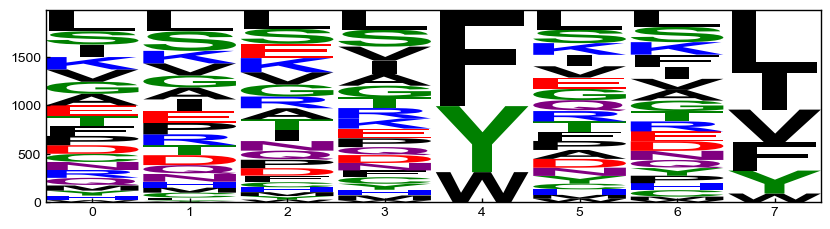

In [35]:
pssms.plot_logo(pssms.alignment_2_counts(df2.head(2000).motif.unique()))

<Axes: >

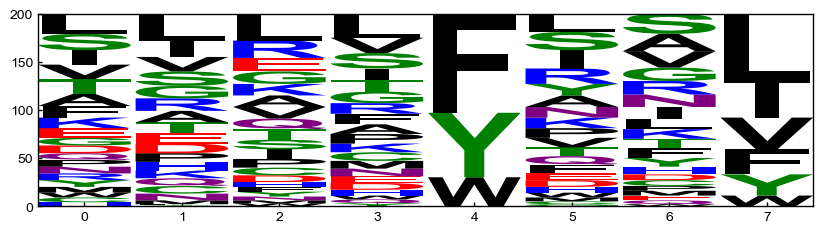

In [36]:
pssms.plot_logo(pssms.alignment_2_counts(df2.head(200).motif.unique()))

<Axes: >

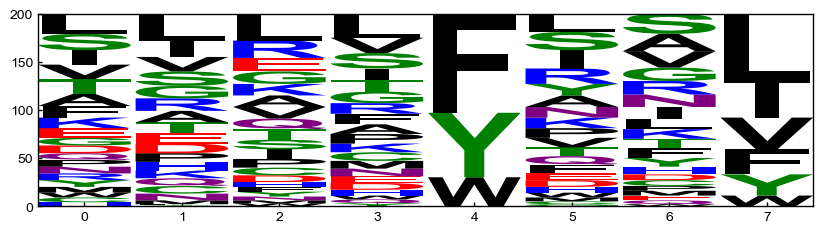

In [40]:
pssms.plot_logo(pssms.alignment_2_counts(df.sort_values(by="ER 1", ascending=True).head(200).motif.unique()))

<Axes: >

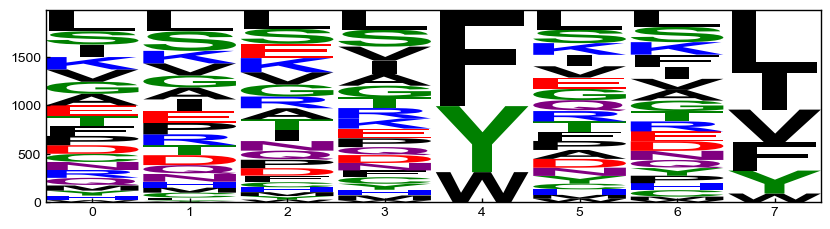

In [41]:
pssms.plot_logo(pssms.alignment_2_counts(df.sort_values(by="ER 1", ascending=True).head(2000).motif.unique()))

## I can't find a nonbinder set with distinct sequence features. This makes a lot of sense, because the non-binder sequences are going to be really diverse. Not sure I should've expected to find anything